In [59]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats 
import datetime as dt
import statsmodels.api as sm
import warnings
from pylab import rcParams
from math import sqrt
from statsmodels.graphics import tsaplots
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import adfuller,q_stat,acf,kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.stattools import durbin_watson
from scipy.special import inv_boxcox

In [60]:
#Data import
data= pd.read_excel('IPG2211A2N.xlsx')
df= data.copy()
df

,observation_date,electricgas
0,1939-02-01,0.76494
1,1939-03-01,2.27144
2,1939-04-01,0.73936
3,1939-05-01,0.00000
4,1939-06-01,1.47076
...,...,...
966,2019-08-01,-1.37282
967,2019-09-01,-8.20740
968,2019-10-01,-9.02977
969,2019-11-01,6.56316


For this project, I chose to work with the Industrial Production of Electric and Gas Utilities data in percent change units, spanning from 1939-01-01 to 2019-12-01. The reason for using percent change is that it allows me to avoid additional transformations, such as differencing, so by using percent change I can achieve a stationarity-like effect without overcomplicating the data.

In [61]:
# cheking if there is any missing values
df.isna()
(df.isna().sum()/df.shape[0]).sort_values(ascending= True)

observation_date    0.0
electricgas         0.0
dtype: float64

In [62]:
# Converting the 'observation_date' column to datetime format
df['observation_date'] = pd.to_datetime(df['observation_date'])
df = df.set_index('observation_date')
df

,electricgas
observation_date,
1939-02-01,0.76494
1939-03-01,2.27144
1939-04-01,0.73936
1939-05-01,0.00000
1939-06-01,1.47076
...,...
2019-08-01,-1.37282
2019-09-01,-8.20740
2019-10-01,-9.02977


# Data Exploration

In [63]:
#summary of the data
df.describe()

,electricgas
count,971.000000
mean,0.572006
std,6.547376
min,-15.973930
25%,-3.585660
50%,0.481980
75%,4.216855
max,23.946580


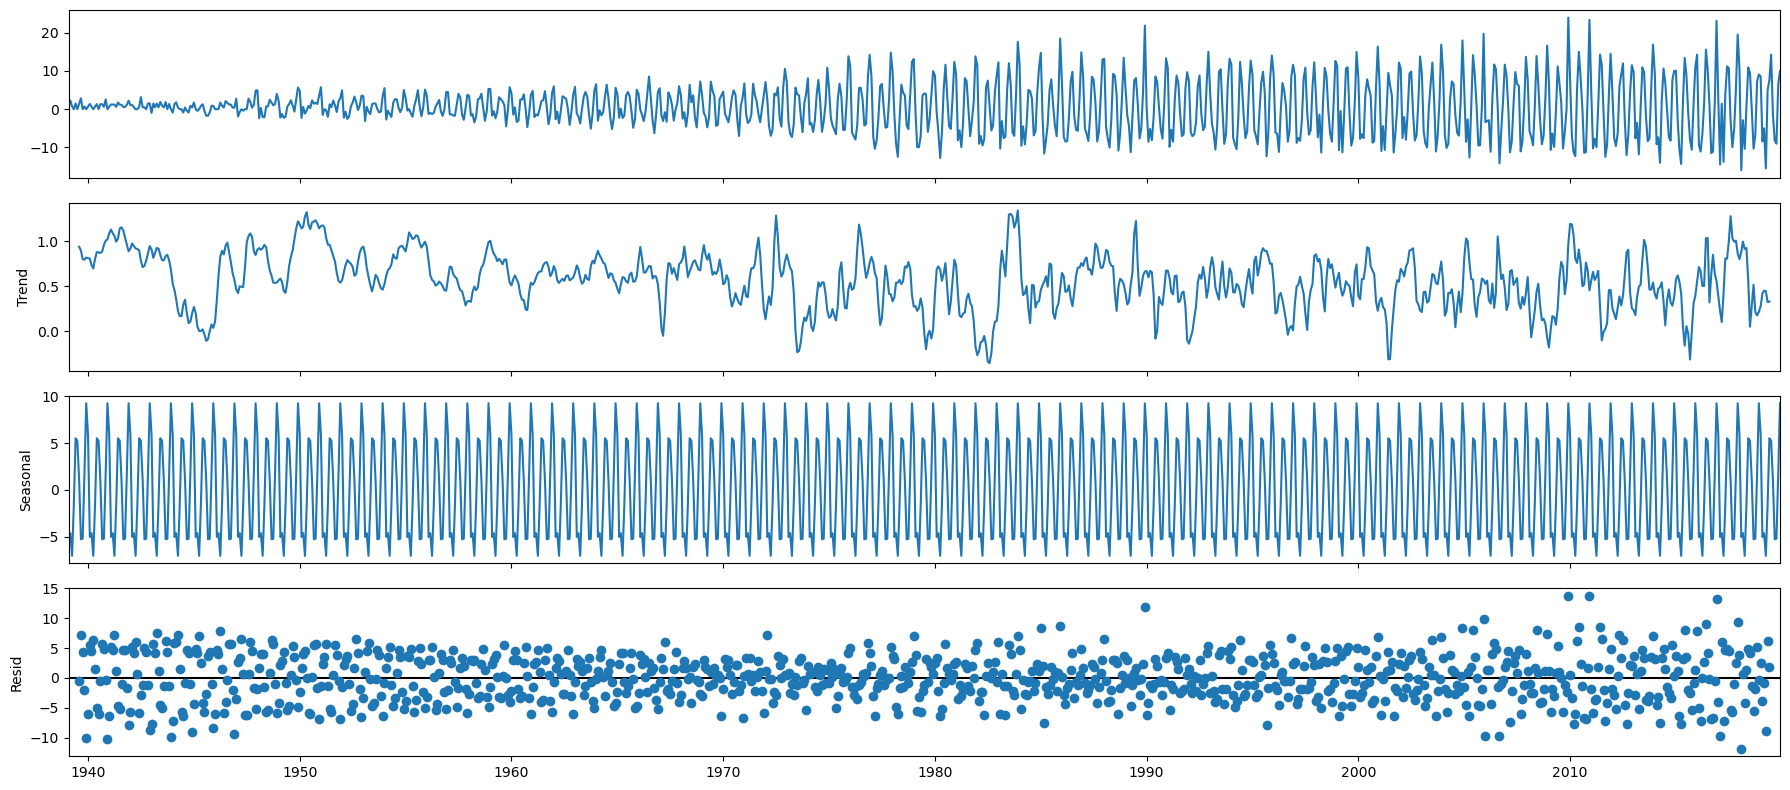

In [65]:
# data decomposition
rcParams['figure.figsize'] = 18,8
decomposition = sm.tsa.seasonal_decompose(df,model='additive')
fig = decomposition.plot()
plt.show()

1/ The series shows noticeable fluctuations and periodic behavior.

2/ The trend shows fluctuating industrial production growth, with periods of acceleration and deceleration.This variability could be driven by economic cycles, seasonal factors, policy changes...

3/ The data appear to exhibit a one-year seasonal pattern, which might be driven by consistent factors such as weather patterns affecting electricity and gas usage.

4/The residual plot seems to be centered around zero, but they show significant deviation (that could indicate unexplained events or outliers).

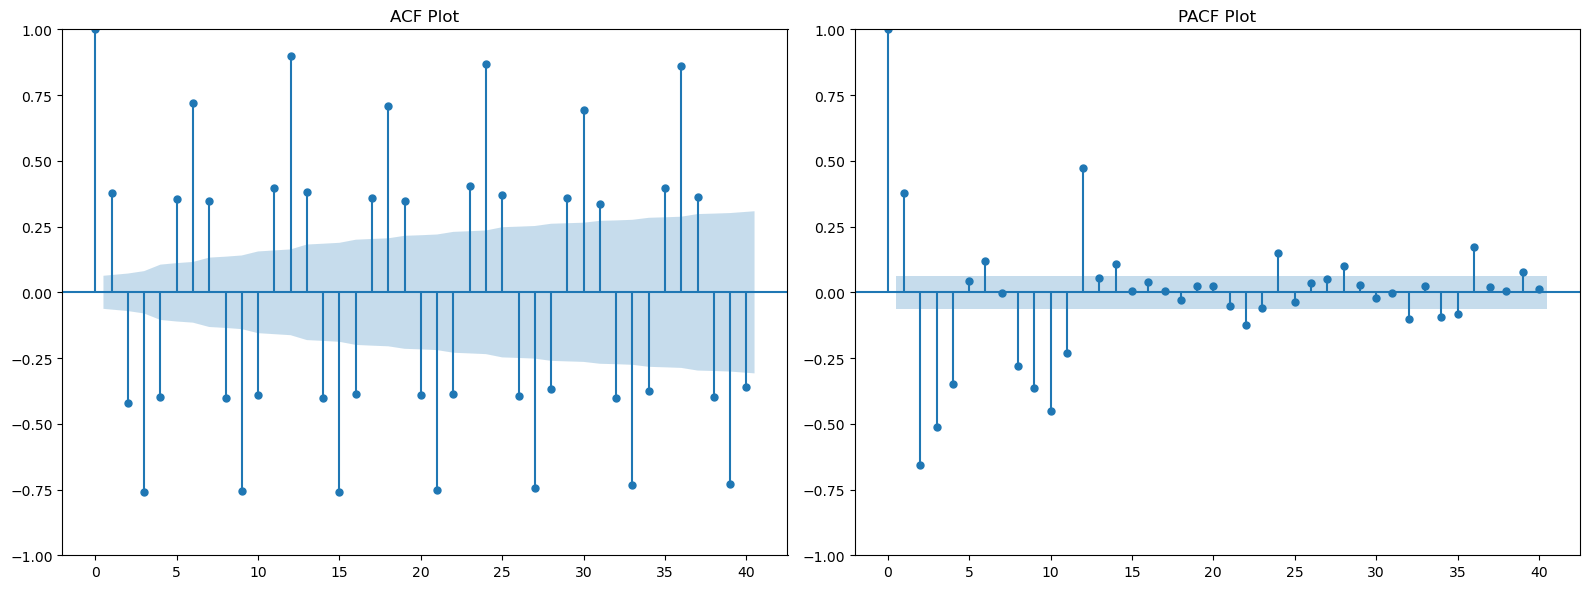

In [68]:
# ACF and PACF
def plot_acf_pacf(df, lags=40):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    # ACF Plot
    plot_acf(df, lags=lags, ax=axes[0])
    axes[0].set_title('ACF Plot')
    # PACF Plot
    plot_pacf(df, lags=lags, ax=axes[1], method='ywm')
    axes[1].set_title('PACF Plot')
    plt.tight_layout()
    plt.show()

plot_acf_pacf(df)

Repeated Pattern in the ACF plot indicating a clear seasonal pattern with significant spikes occurring at regular intervals, also it shows a gradual decrease.
There is a sharp drop after lag 1 in the PACF plot, it also suggests a seasonal component with a period of 12 (spike at lag 12).

In [69]:
# ADF test for stationarity
def adfuller_test(series, signif=0.05):
    """This function conducts the ADF test to check for stationarity"""
    """Inputs are series=data on which we perform the test, signif=significance level (usually 0.05)"""
    """Returns a decision based on the p-value"""
    p_value = adfuller(series)[1]
    if p_value <= signif:
        print("Series is Stationary.")
    else:
        print("Series is Non-Stationary.")

adfuller_test(df['electricgas'], 0.05)

# Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test for stationarity
def kpss_test(series, signif=0.1):
    """This function conducts the KPSS test to check for stationarity"""
    """Inputs are series=data, signif=significance level"""
    """If p-value is <= 0.01, the data is non-stationary. If p-value <= 0.1, the data is stationary."""
    warnings.filterwarnings("ignore", message=".*test statistic is outside of the range.*")
    p_value = kpss(series, regression='c')[1]
    if p_value <= 0.01:
        print("Series is Non-Stationary.")
    elif p_value <= signif:
        print("Series is Stationary.")
    else:
        print("Series is Non-Stationary.")

kpss_test(df, 0.1)

Series is Stationary.
Series is Stationary.


# Splitting data

In [71]:
def split(df,nobs):
    """this function is for creating trainset and testset """
    """inputs are the data and the number of observation of the testset"""
    """returns shape of the train and test set"""
    df_train, df_test = df[0:-nobs], df[-nobs:]
    print(df_train.shape) 
    print(df_test.shape)
    return df_train, df_test

df_train, df_test=split(df,292)   

(679, 1)
(292, 1)


In [72]:
#cheking the stationarity of train set
adfuller_test(df_train, 0.05)
kpss_test(df_train,0.1)

Series is Stationary.
Series is Stationary.


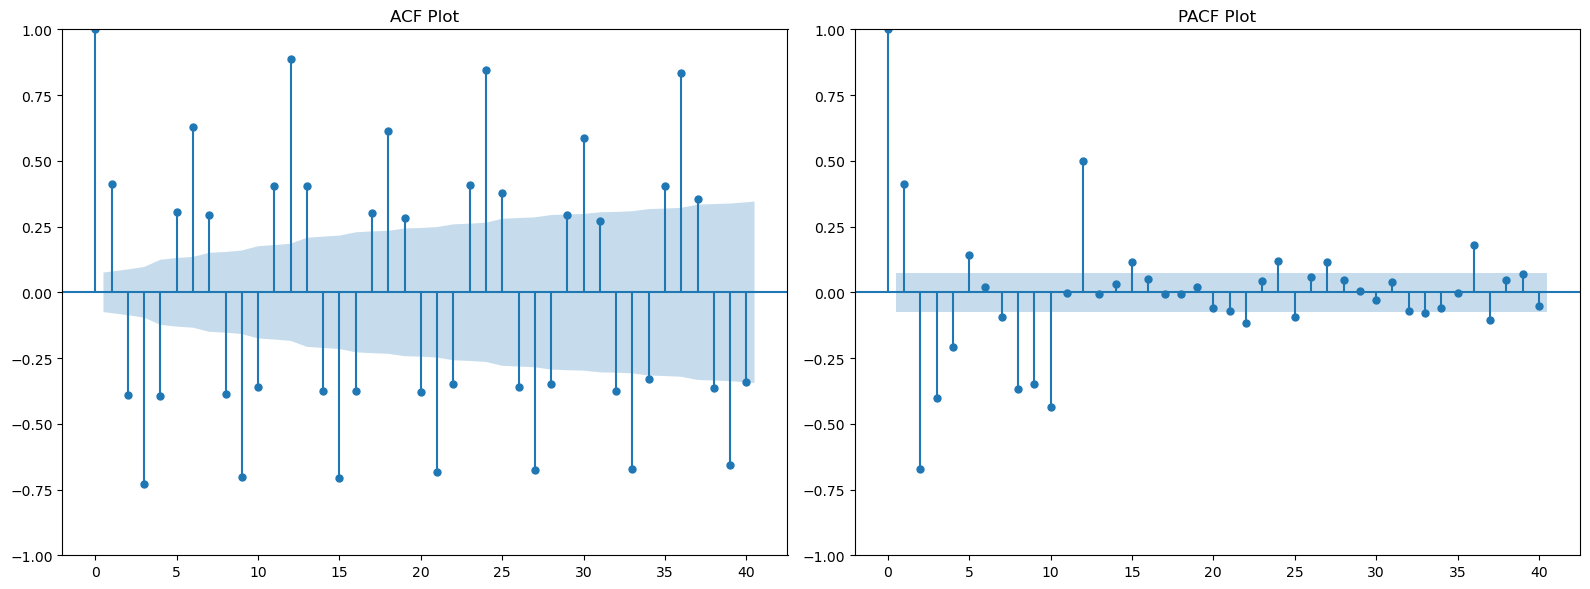

In [73]:
plot_acf_pacf(df_train)

Before modeling, we need to choose the right model and its parameters. After plotting the ACF and PACF, we can see seasonality in the ACF, which suggests that seasonal differencing (D=1) might be needed, making SARIMA a good choice. From the PACF, we observe a sharp drop at lag 1, so we start with p=1. A small peak around lag 12 indicates a seasonal AR term, suggesting a seasonal period of 12 (m=12). I'll begin with p=1 and q=0, I’ll adjust by increasing p or adding q. For the seasonal components, I'll set P=1, Q=1, and D=1 to capture seasonality, and modify if needed. Given the structure observed in the ACF and PACF plots, there's no need for higher orders than 2 for p,q,P and Q, as increasing complexity could overfit the model without improving performance.

# Model training

In [74]:
def modelling(df,p,d,q,P,D,Q):
    """this function is for fitting the model the inputs are the data and the chosen orders"""
    """it returns summary of the fitted model, the residuals and fitted values"""
    df = df.asfreq('MS')
    #SARIMAX(p,d,q)(P,D,Q)m
    models = SARIMAX(df,order=(p,d,q),seasonal_order=(P,D,Q,12))
    models_fit = models.fit()
    residuals=models_fit.resid
    predictions=models_fit.fittedvalues
    print(models_fit.summary())
    return models_fit, residuals, predictions
#trial    
models_fit1, residuals1, predictions1= modelling(df_train,1,0,0,1,1,1)
models_fit2, residuals2, predictions2= modelling(df_train,1,0,1,1,1,1)
models_fit3, residuals3, predictions3= modelling(df_train,1,0,2,1,1,1)

                                      SARIMAX Results                                       
Dep. Variable:                          electricgas   No. Observations:                  679
Model:             SARIMAX(1, 0, 0)x(1, 1, [1], 12)   Log Likelihood               -1386.280
Date:                              Thu, 21 Nov 2024   AIC                           2780.561
Time:                                      11:50:56   BIC                           2798.572
Sample:                                  02-01-1939   HQIC                          2787.538
                                       - 08-01-1995                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0027      0.026      0.102      0.919      -0.049       0.054
ar.S.L12       0.03

This is a manual method which allows for quick and easy adjustments to the model orders. However, it can be time-consuming when trying to find the best model. So it's better to use a loop or an automated approach, such as pmdarima to find the best-fitting model.

In [76]:
def best_model(df, p_values, d, q_values, P_values, D, Q_values, s):
    """this function finds the best model by iterating over different combinations of model orders"""
    """ Inputs are the data, a list of the values of orders for p,q,P and Q, and values of d,D,s"""
    """returns best model with the lowest AIC"""
   # Initialisation
    best_model = None
    df = df.asfreq('MS')
    # Loop
    for p in p_values:
        for q in q_values:
            for P in P_values:
                for Q in Q_values:
                    model = SARIMAX(df, order=(p, d, q), seasonal_order=(P, D, Q, s))
                    result = model.fit(disp=False)
                    if best_model is None or result.aic < best_model.aic:
                        best_model = result
    
    return best_model

model = best_model(df_train, [0, 1, 2] , 0, [0, 1, 2] ,[1, 2] , 1, [1, 2] , 12)
print(model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                          electricgas   No. Observations:                  679
Model:             SARIMAX(1, 0, 2)x(2, 1, [1], 12)   Log Likelihood               -1357.682
Date:                              Thu, 21 Nov 2024   AIC                           2729.364
Time:                                      11:53:04   BIC                           2760.884
Sample:                                  02-01-1939   HQIC                          2741.575
                                       - 08-01-1995                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5196      0.092      5.621      0.000       0.338       0.701
ma.L1         -0.57

In [77]:
models_fit, residuals, predictions= modelling(df_train,1,0,2,2,1,1)

                                      SARIMAX Results                                       
Dep. Variable:                          electricgas   No. Observations:                  679
Model:             SARIMAX(1, 0, 2)x(2, 1, [1], 12)   Log Likelihood               -1357.682
Date:                              Thu, 21 Nov 2024   AIC                           2729.364
Time:                                      11:53:36   BIC                           2760.884
Sample:                                  02-01-1939   HQIC                          2741.575
                                       - 08-01-1995                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5196      0.092      5.621      0.000       0.338       0.701
ma.L1         -0.57

The coefficients for both the non-seasonal and seasonal parts of the model are statistically significant.
The residuals exhibit no significant autocorrelation (Ljung-Box), but there is some evidence of heteroskedasticity and non-normality (Jarque-Bera)

# Residual diagnosis / Model performance evaluation

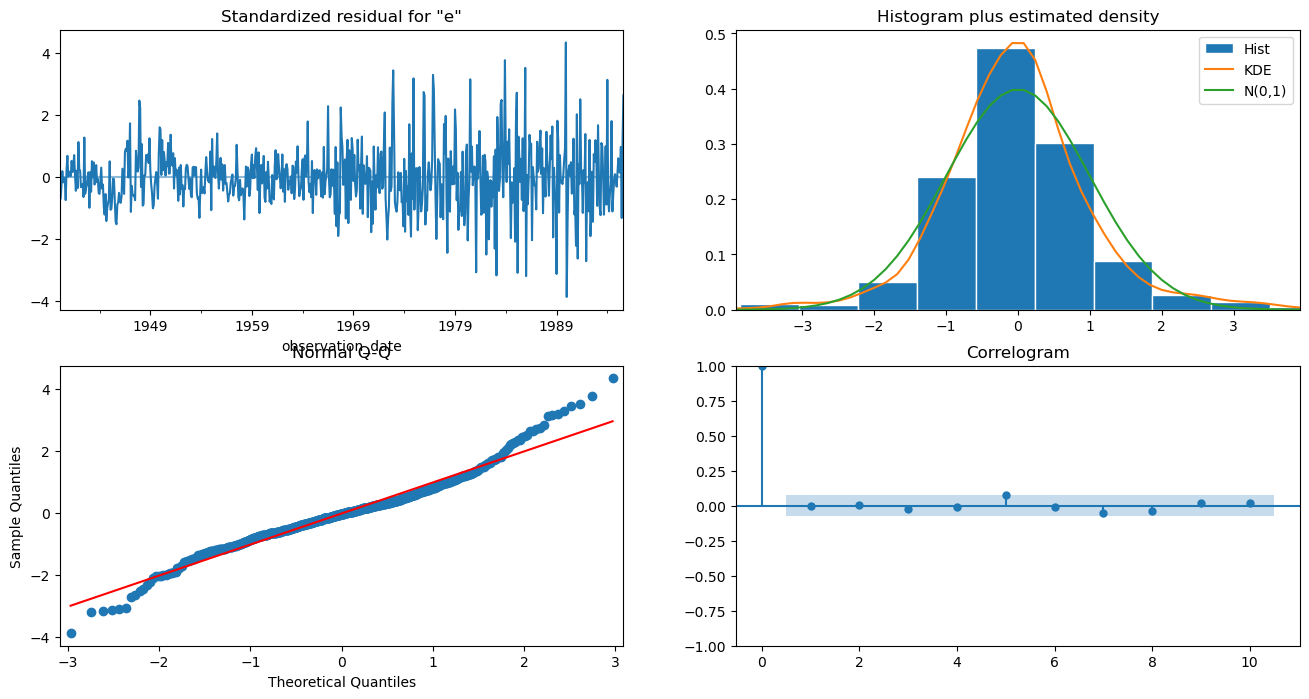

In [78]:
# Plot
residuals_data = pd.DataFrame(residuals)
models_fit.plot_diagnostics(figsize = (16,8))
plt.show()

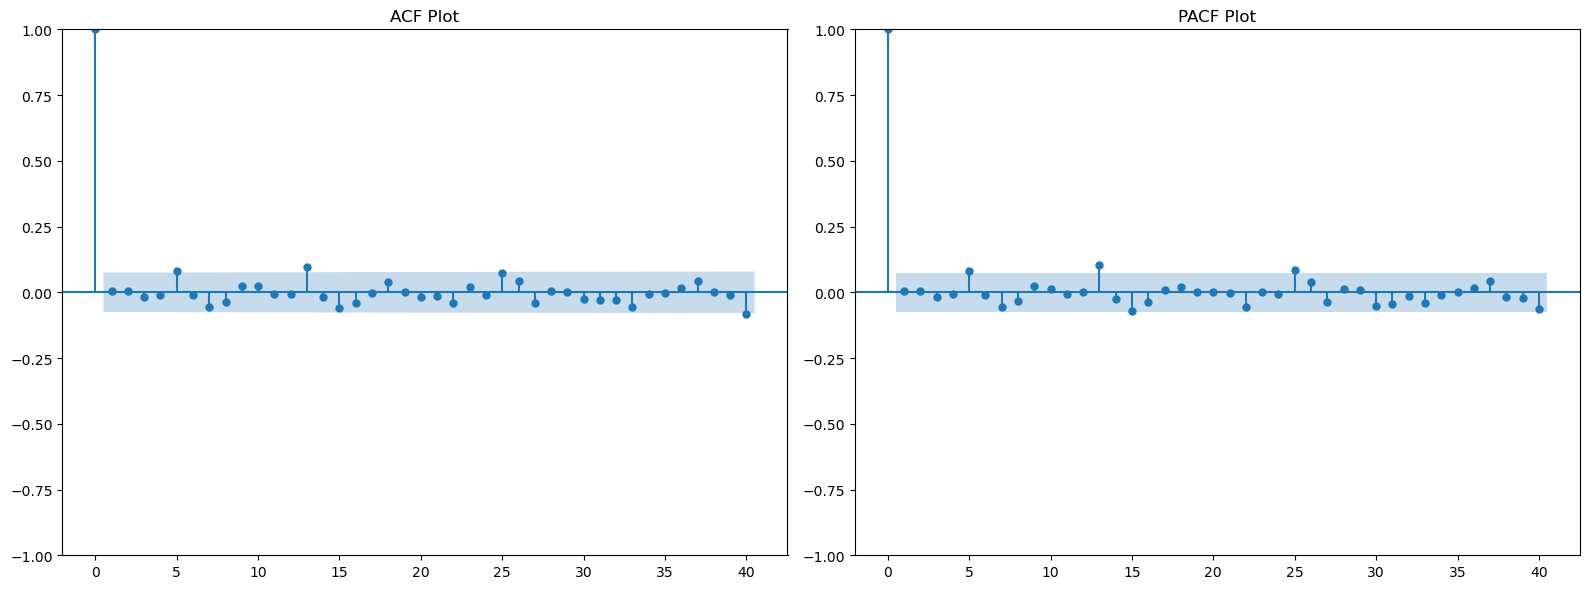

Series is Stationary.
Series is Stationary.


In [79]:
#Stationarity check of the residuals of the model
plot_acf_pacf(residuals)
adfuller_test(residuals, 0.05)
kpss_test(residuals,0.1)

In [80]:
#Auto Correlation for residuals
def Durbin_watson_test(df):
    """this function perform dubin_watson test on the residuals of the model"""
    """"the input is the residuals of the model it return the p-value of the test"""
    out = durbin_watson(df)
    print('Durbin waston p-value is',round(out,3))
Durbin_watson_test(residuals)

Durbin waston p-value is 1.979


The Durbin-Watson test, which ranges from 0 to 4, assesses the presence of serial correlation in residuals. A value close to 2 indicates no significant serial correlation, while values closer to 0 or 4 suggest positive or negative correlation, respectively. In this case, the Durbin-Watson test value is 1.979, implying no significant serial correlation. The ACF plot of the residuals also shows a rapid decline towards zero, supporting the conclusion that no auto-correlation is present in the residuals

In [81]:
#Normality check on residuals
def jarque_bera_test(df):
    """this function conducts jarque berra test, the input is the residuals of the model"""
    """it return the p-value of the test and a message indicating whether the residuals are normally dis or not"""
    """If the p-value of the test is greater than α = 0.05, then the data is assumed to be normally distributed."""
    jarque_bera=stats.jarque_bera(df)
    if jarque_bera[1] >= 0.05:
        print('Jarque Bera p-value is' , round(jarque_bera[1],3), '=> Residuals are normally distributed')
    else:
        print('Jarque Bera p-value is' ,round(jarque_bera[1],3), '=> Residuals are not normally distributed')
jarque_bera_test(residuals_data)

Jarque Bera p-value is 0.0 => Residuals are not normally distributed


The histogram, portraying the distribution of the residuals, and the Q-Q plot, where the distribution of the residuals is compared to a theoretical
 normal distribution, indicates that none of the residuals have a normal distribution. This is supported by the Jarque-Bera test values, which
 confirm the non-normality. 

# Visualisation actual vs prediction on trainset

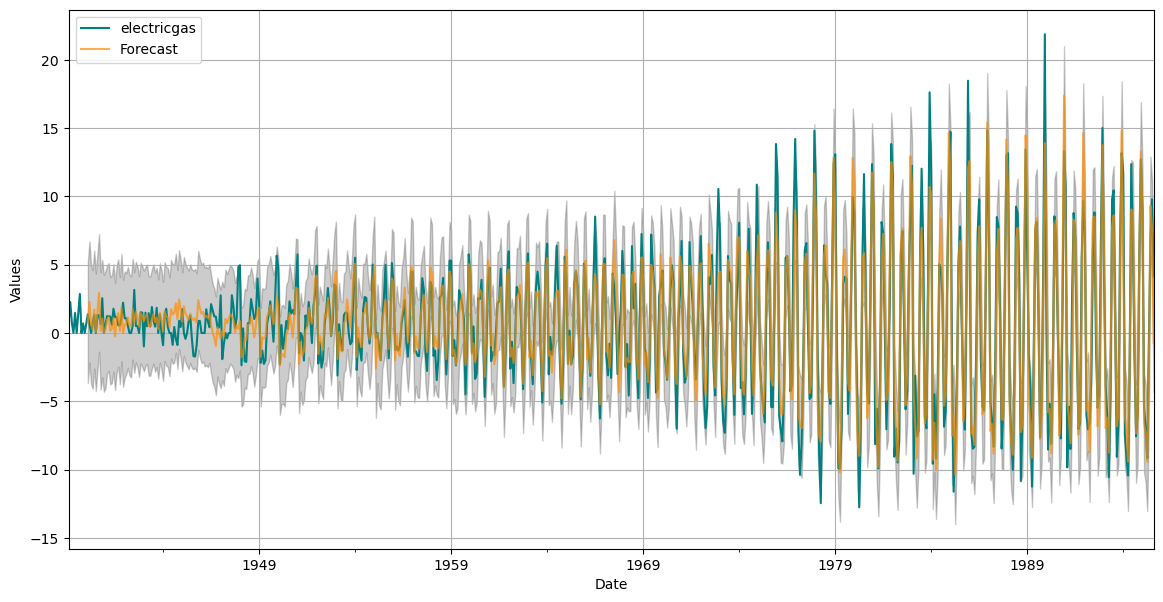

In [102]:
def get_prediction_visualisation(df, start, end,models_fit):
    """This function is designed to visualize the original data and the forecasted values along with their confidence intervals"""
    """ As input it takes the data, the start date, the end date and models_fit"""
    """Everything else is decoration it can be adjustable to anyone likeness(colors,figsize...)"""
    rcParams['figure.figsize'] = 18,9
    pred = models_fit.get_prediction(start=pd.to_datetime(start),end=pd.to_datetime(end), dynamic=False)
    pred_ci = pred.conf_int(alpha=.05)
    ax = df.plot(color='teal')
    pred.predicted_mean.plot(ax=ax, label='Forecast',color='darkorange', alpha=.7, figsize=(14, 7))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)
    ax.set_xlabel('Date')
    ax.set_ylabel('Values')
    plt.grid(True)
    plt.legend()
    plt.show()
get_prediction_visualisation(df_train, '1940-02-01', '1995-08-01',models_fit)

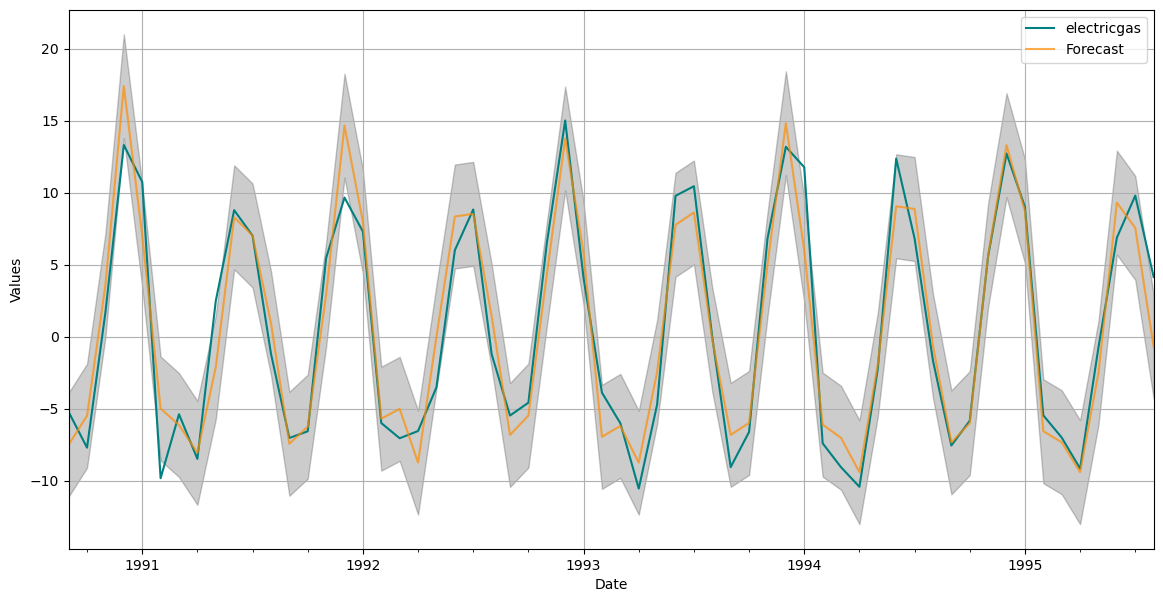

In [103]:
#Zoom
get_prediction_visualisation(df_train['1990-09-01': '1995-08-01'], '1990-09-01', '1995-08-01',models_fit)

The model appears to capture the overall pattern of the data, with the predicted values closely following the actual values. However, there are slight deviations between the forecast and actual values, particularly at the peaks and lows suggesting that the model may be less accurate during periods of extreme fluctuations. Also, the predictions fall within the confidence interval indicating that the model's uncertainty estimates are reasonable.

In [104]:
def metrics(df,predictions):
    """this function is used to evaluate the performance of the model by calculating mae, mse, rmse"""
    """ Inputs are the data and the predicted values"""
    #Calculate mean absolute error
    mae = mean_absolute_error(df,predictions)
    print('MAE: %f' % mae)
    #Calculate mean squared error and root mean squared error
    mse = mean_squared_error(df,predictions)
    print('MSE: %f' % mse)
    rmse = sqrt(mse)
    print('RMSE: %f' % rmse)
metrics(df_train,predictions)

MAE: 1.334087
MSE: 3.372144
RMSE: 1.836340


The closer the values of the metrics to 0, the better the model is. Overall, the model performs reasonably well and captures the general trends of the data. The MAE value indicates a reasonable error margin. However, since RMSE is higher than MAE, it suggests that the model may occasionally experience significant deviations, indicating that while the model is generally reliable, some larger errors are present.

# Test set 

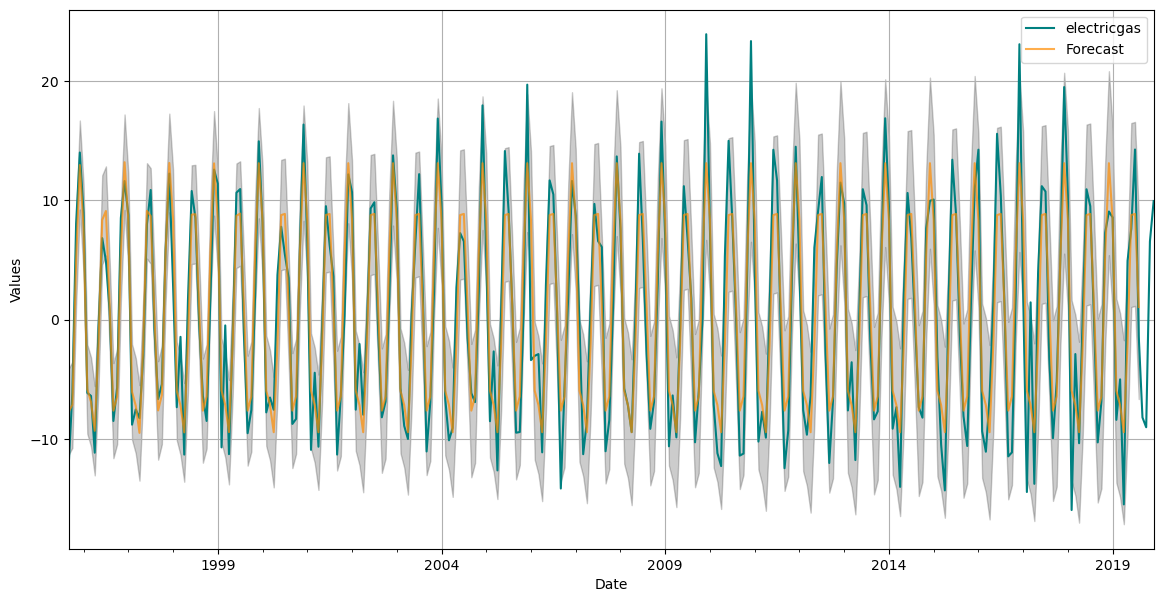

In [105]:
get_prediction_visualisation(df_test, '1995-09-01', '2019-08-01',models_fit)

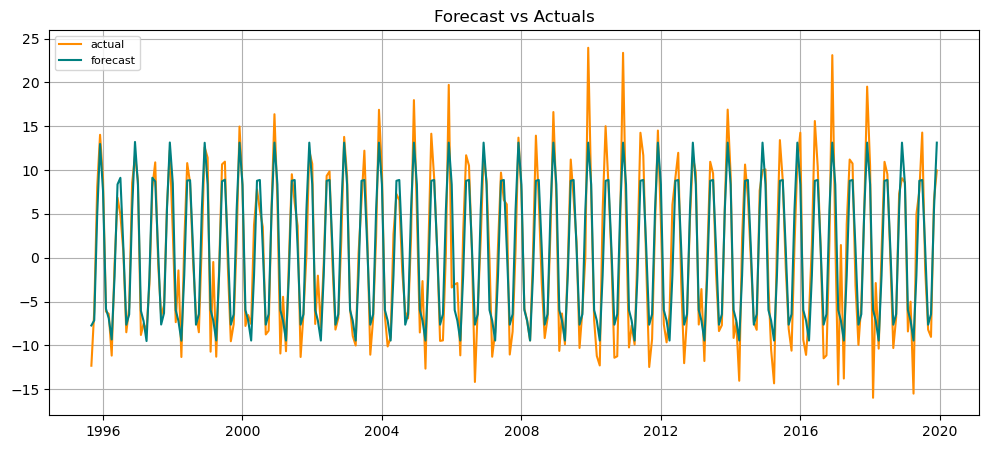

In [106]:
# Forecast
def forecast(df,models_fit):
    """This function forecasts future values based on the trained model"""
    """ Inputs are the data and the number of future observations (nobs=len(test set)) to forecast and models_fit values"""
    nobs=len(df)
    fc = models_fit.forecast(nobs, index=df.index)
    # Make as pandas series
    fc_series = pd.Series(fc, index=df.index)
    # Plot
    plt.figure(figsize=(12,5))
    plt.plot(df, label='actual', color='darkorange') 
    plt.plot(fc_series ,label='forecast', color='teal')
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8)
    plt.grid(True)
    plt.show()
    return fc_series
    
fc_test_series=forecast(df_test, models_fit)

Although the general pattern of the data is still followed as in the training set, the model is not able to predict the specific
 peaks and lows that occurs in the test set. This is because time series models, such as SARIMA, are based on the assumption that past patterns will continue into the future. They are not designed to predict events that are outside the historical time frame, such as major economic crises or global pandemics. Also, the predictions on the test set fall within the confidence interval except for the extreme peaks in the original data that fall outside the interval. This confirms that the model is able to capture the general pattern of the data, but struggles to predict unusual events that fall outside of the predicted range.

In [107]:
metrics(df_test,fc_test_series)

MAE: 2.595870
MSE: 10.990150
RMSE: 3.315140


The increase in MAE, MSE, and RMSE suggests that the model is not generalizing as well as it did on the training data.

# Reforecast

The main issues with the model are non-normal residuals and heteroskedasticity (the variance of the residuals varies across different levels of the independent variable). These problems can negatively impact the model performance. By addressing these issues, the model's predictions can be improved. One approach is to use the Box-Cox transformation, which helps stabilize the variance and make the data more normally distributed. This transformation can potentially address both non-normality and heteroskedasticity,

In [108]:
# Box-Cox transformation to address the non-normality.
def box_cox_transformation(df, constant):
    """ This function applies the Box-Cox transformation."""
    """Inputs are the data and a specified constant (that make the data positive"""
    """returns the transformed data and lambda value used for the transformation."""
    df.index = pd.to_datetime(df.index)
    transformed_data, lambda_val = stats.boxcox(df.electricgas+constant)
    transformed_data_indexed = pd.Series(transformed_data, index=df.index, name='Transformed Data')
    print("Lambda Value:", lambda_val)
    return transformed_data, transformed_data_indexed, lambda_val

transformed_data, transformed_data_indexed,lambda_val =  box_cox_transformation(df_train, 13)

Lambda Value: 0.7831563013023173


In [109]:
def inv_box_cox_transformation(transformed_data, lambda_val ,constant):
    """this function reverses the Box-Cox transformation. It takes the transformed data, the lambda value, and the constant"""
    """ returns the original data"""
    original_data = inv_boxcox(transformed_data, lambda_val) - constant
    return original_data

In [110]:
results = best_model(transformed_data_indexed, [0, 1, 2] , 0, [0, 1, 2] ,[1, 2] , 1, [1, 2] , 12)
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                   Transformed Data   No. Observations:                  679
Model:             SARIMAX(2, 0, 1)x(2, 1, 1, 12)   Log Likelihood                -993.663
Date:                            Thu, 21 Nov 2024   AIC                           2001.326
Time:                                    12:05:25   BIC                           2032.845
Sample:                                02-01-1939   HQIC                          2013.537
                                     - 08-01-1995                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7122      0.059     12.014      0.000       0.596       0.828
ar.L2         -0.1905      0.036   

In [111]:
new_models_fit, new_residuals, new_predictions= modelling(transformed_data_indexed,2,0,1,2,1,1)

                                     SARIMAX Results                                      
Dep. Variable:                   Transformed Data   No. Observations:                  679
Model:             SARIMAX(2, 0, 1)x(2, 1, 1, 12)   Log Likelihood                -993.663
Date:                            Thu, 21 Nov 2024   AIC                           2001.326
Time:                                    12:07:24   BIC                           2032.845
Sample:                                02-01-1939   HQIC                          2013.537
                                     - 08-01-1995                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7122      0.059     12.014      0.000       0.596       0.828
ar.L2         -0.1905      0.036   

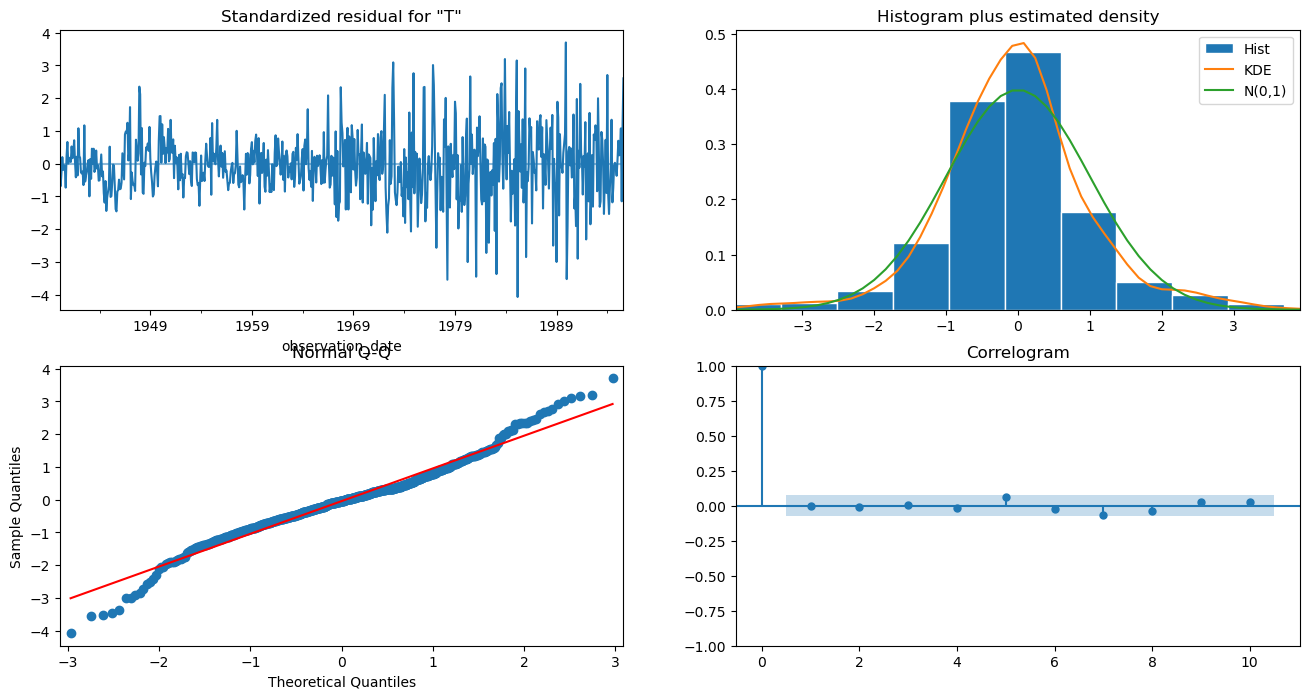

In [112]:
new_models_fit.plot_diagnostics(figsize = (16,8))
plt.show()

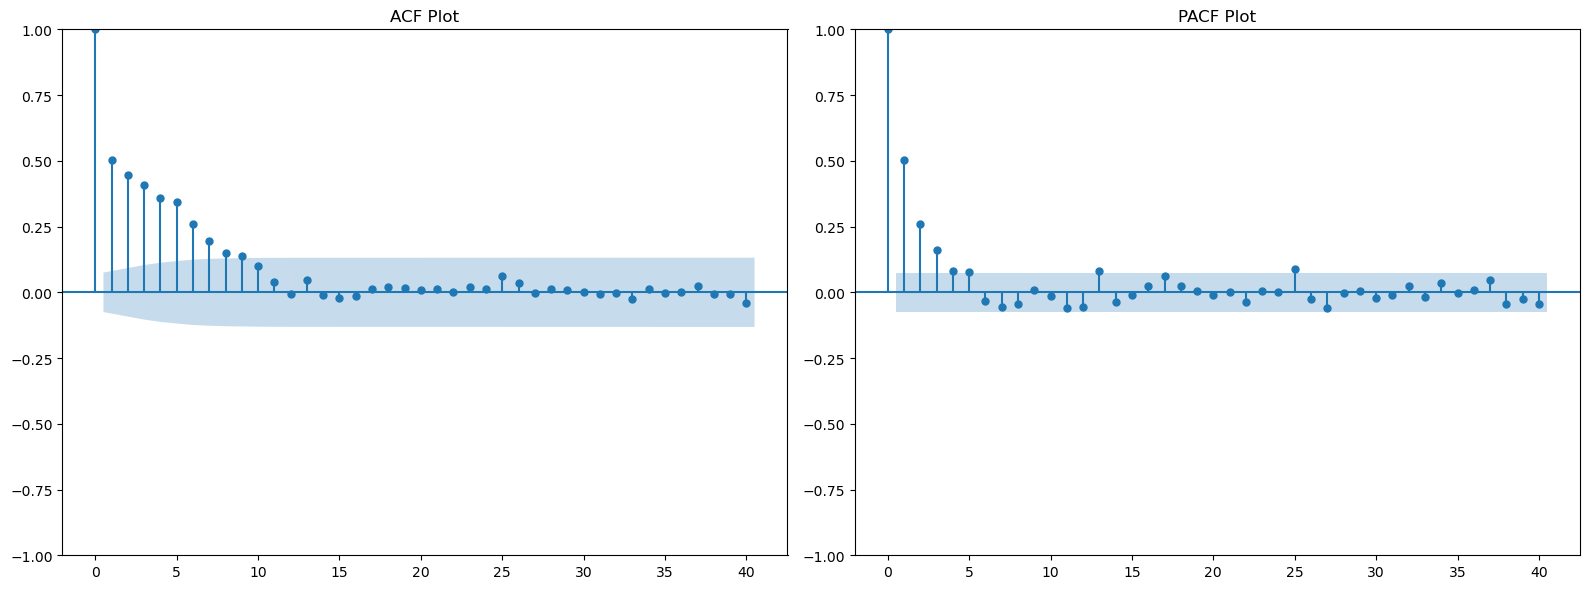

Series is Stationary.
Series is Stationary.


In [113]:
#Stationarity check of the residuals of the model
plot_acf_pacf(new_residuals)
adfuller_test(new_residuals, 0.05)
kpss_test(new_residuals,0.1)

In [114]:
#Auto Correlation for residuals
def Durbin_watson_test(df):
    """this function perform dubin_watson test on the residuals of the model"""
    """"the input is the residuals of the model it return the p-value of the test"""
    out = durbin_watson(df)
    print('Durbin waston p-value is',round(out,3))
Durbin_watson_test(new_residuals)

Durbin waston p-value is 0.943


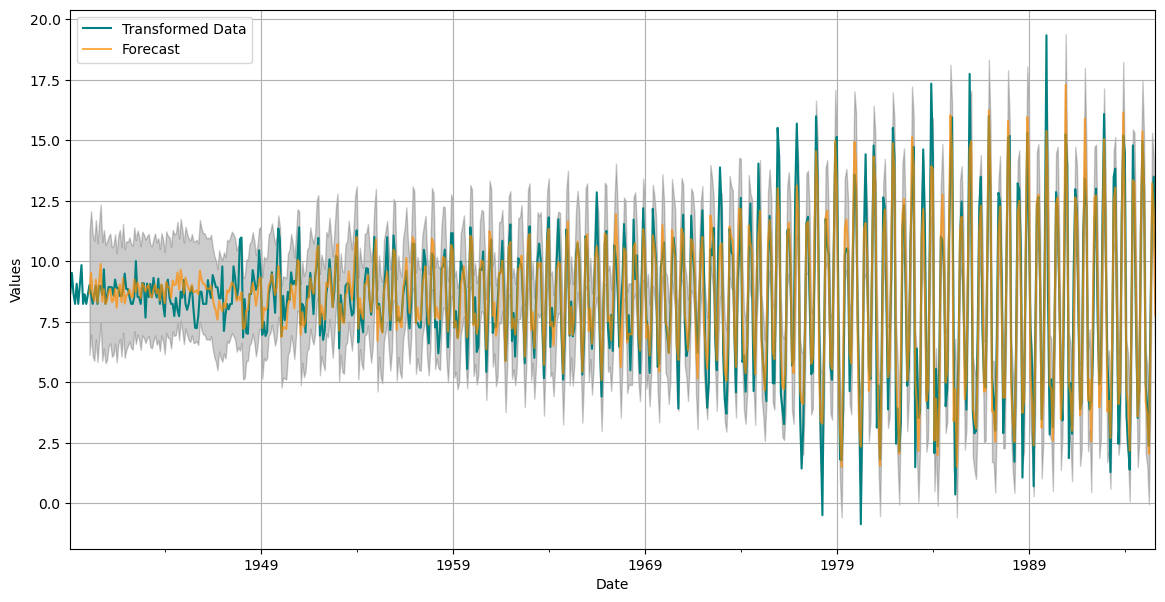

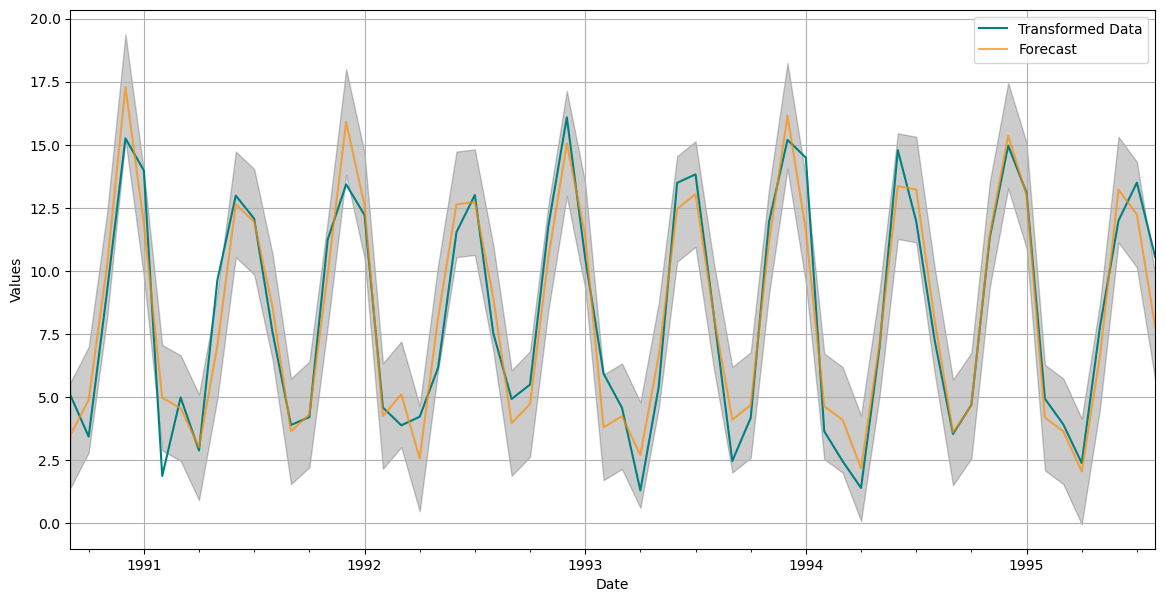

In [117]:
get_prediction_visualisation(transformed_data_indexed, '1940-02-01', '1995-08-01',new_models_fit)
#zoom
get_prediction_visualisation(transformed_data_indexed['1990-09-01':'1995-08-01'], '1990-09-01', '1995-08-01',new_models_fit)

In [118]:
metrics(transformed_data_indexed,new_predictions) 

MAE: 0.922350
MSE: 2.482404
RMSE: 1.575565


The Jarque-Bera test values obtained indicate that the  residuals are still not normally distributed even after the transformation.
So it's true that the Box-Cox transformation has helped in improving the normality of the data to some extent (value of JB is smaller, values of kurtosis and skew are closer to 3 and 0, respectively). However, it did not result in a perfectly normal distribution. It can be difficult to obtain a perfect normal distribution in real life data, this emphasize the need to consider the limitations of the normality assumption and its potential effect on the accuracy and reliability of model predictions.

Additionally, we still observe the heteroskedasticity and despite the residuals being stationary as confirmed by the ADF and KPSS tests, the ACF plot shows a slower decay towards zero, and the Durbin-Watson test value of 0.943 indicates increasing positive autocorrelation. On a positive note, the model's performance metrics have improved slightly, suggesting some enhancement in model accuracy. 

In [119]:
def new_forecast(df, nobs, models_fit):
    fc = models_fit.forecast(nobs, index=df.index)
    original_predictions =  inv_box_cox_transformation(fc, 0.78 ,13)
    fc_series = pd.Series(original_predictions, index=df.index)
    # Plot
    plt.figure(figsize=(12,5))
    plt.plot(df, label='actual', color='darkorange') 
    plt.plot(fc_series ,label='forecast',color='teal')
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8)
    plt.show()
    return fc_series
#this new_forecast function has an inverse Box-Cox transformation to ensure that the forecasts are presented in the original scale of the data.

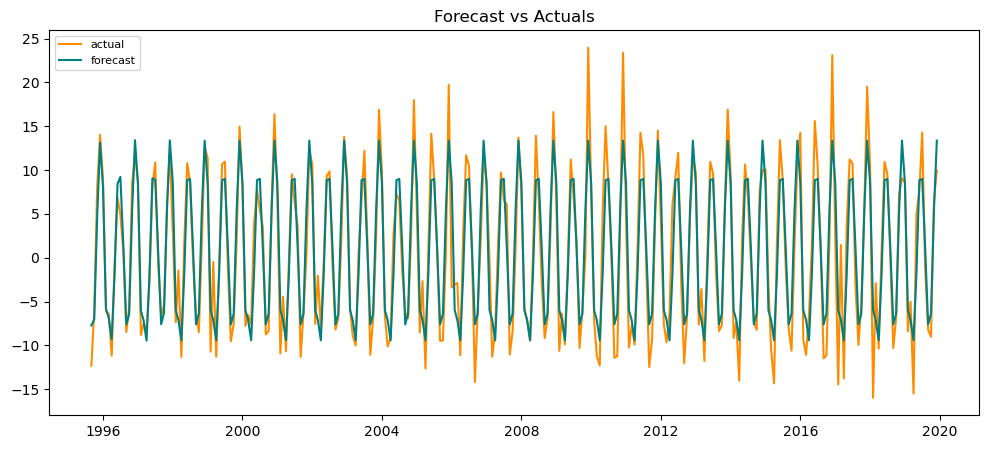

In [120]:
fc_test_serie = new_forecast(df_test, 292, new_models_fit)

In [121]:
metrics(df_test,fc_test_serie)

MAE: 2.585647
MSE: 10.867443
RMSE: 3.296580


There was only a slight improvement in the metric values, almost negligible, so it seems that this approach did not yield significant results.

Overall, no significant improvement is observed. This can be attributed to the presence of extreme values in the data indicating that regardless of the transformations or modeling techniques applied, time series models may not be able to accurately capture sudden changes that have not occurred in the past.